# Business questions using SQL

## Introduction

- Popentially atractive market to expand
- Sales by country
- Which new bands to promote
- Employee performance
- Customers behaviour


### Summary of results

Results show that all emloyees have similar performances which depends mostly on seniority level. There are some potentially atractive markets to advertise the compaign like: India or Czech. Customers tend to buy individual tracks in 80% cases while 20% of total income comes from selling whole albums. The Red tone producing Punk has the biggest chance to hit the tastes as this type of music is over 10% of the market.

## Data exploration

Importing modules and connecting to sql database

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# function that returns dataframe of the given query
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query,conn)
    
# function that executes sql command without printing
def run_command(query):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(query)

# function that prints the database tables and views
def show_tables():
    with sqlite3.connect('chinook.db') as conn:
        query = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view')"
        cursor = conn.cursor()
        cursor.execute(query)
        return cursor.fetchall()
#         return pd.read_sql(query,conn)

In [3]:
show_tables()

[('album', 'table'),
 ('artist', 'table'),
 ('customer', 'table'),
 ('employee', 'table'),
 ('genre', 'table'),
 ('invoice', 'table'),
 ('invoice_line', 'table'),
 ('media_type', 'table'),
 ('playlist', 'table'),
 ('playlist_track', 'table'),
 ('track', 'table'),
 ('countries_one_customer', 'view')]

## Data insights

### Most popular genres in the USA

We need to check which of these artists have the biggest chance to succeed basend on popularity of the genre.

|Artist name | Genre|
| --- | --- |
|Regal | Hip-Hop|
|Red Tone | Punk|
|Meteor and the Girls | Pop|
|Slim Jim Bites | Blues|



In [4]:
# number of track sold for each genre - absolute number, percentage
genre_sales_usa = run_query('''
          WITH 
          invoice_info AS
          (SELECT 
          COUNT(invoice_id) as track_sold, 
          track_id 
          FROM invoice_line 
          GROUP BY track_id),
          
          track_info AS
          (SELECT 
          t.track_id,
          t.genre_id,
          g.name
          FROM track as t
          LEFT JOIN genre as g ON g.genre_id = t.genre_id)
          
          SELECT 
          SUM(track_sold) as track_sold_per_genre,
          ROUND(CAST(SUM(track_sold) as Float) / (SELECT COUNT(*) FROM invoice_line) *100,2)
          as track_sold_per_genre_percentage,
          name as genre
          FROM invoice_info as i
          LEFT JOIN track_info as ti ON ti.track_id = i.track_id
          GROUP BY genre_id
          ORDER BY 1 DESC
          ''')

In [5]:
genre_sales_usa

,track_sold_per_genre,track_sold_per_genre_percentage,genre
0,2635,55.39,Rock
1,619,13.01,Metal
2,492,10.34,Alternative & Punk
3,167,3.51,Latin
4,159,3.34,R&B/Soul
5,124,2.61,Blues
6,121,2.54,Jazz
7,117,2.46,Alternative
8,74,1.56,Easy Listening
9,63,1.32,Pop


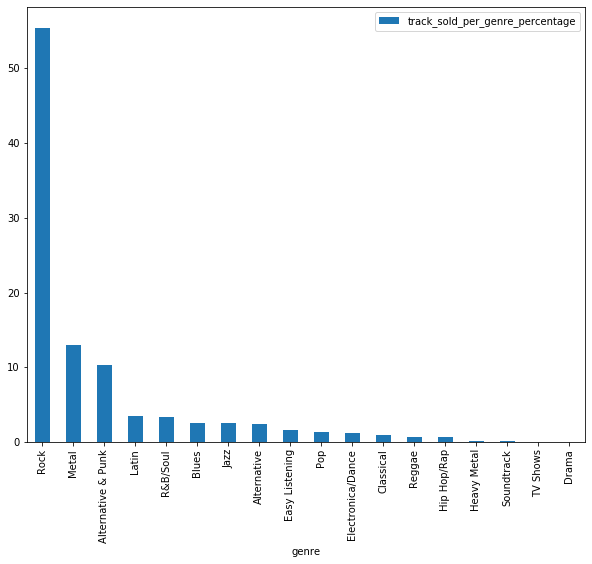

In [6]:
fig,ax = plt.subplots(figsize=(10,8))
genre_sales_usa.plot(ax=ax,kind='bar', x= 'genre',y='track_sold_per_genre_percentage')

We need to chose 3 artists so based on our analysis we can say that:
- Red tone producing Punk has the biggest chance to hit the tastes as this type of music is over 10% of the market,
- Slim Jim Bites with Blues which occupies over 2.5 % of the market,
- Meteor and the Girls with Pop music which shares around 1.3 % of the market.
- Hip-hop is not such popular.


### Checking employee performance

Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.

In [7]:
employee_sales = run_query('''
            SELECT 
            (e.first_name||' '||e.last_name) as employee_name,
            e.title,
            e.hire_date,
            SUM(i.total) as total_sale
            FROM employee as e
            LEFT JOIN customer as c ON e.employee_id = c.support_rep_id
            LEFT JOIN invoice as i ON i.customer_id = c.customer_id
            GROUP BY e.employee_id
            ''')

In [8]:
employee_sales

,employee_name,title,hire_date,total_sale
0,Andrew Adams,General Manager,2016-08-14 00:00:00,NaN
1,Nancy Edwards,Sales Manager,2016-05-01 00:00:00,NaN
2,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
3,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
4,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92
5,Michael Mitchell,IT Manager,2016-10-17 00:00:00,NaN
6,Robert King,IT Staff,2017-01-02 00:00:00,NaN
7,Laura Callahan,IT Staff,2017-03-04 00:00:00,NaN


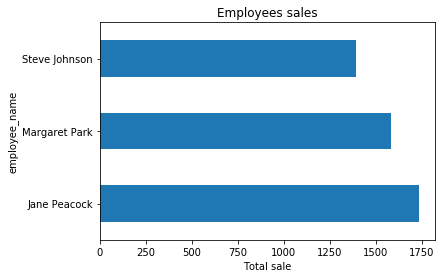

In [9]:
fig,ax = plt.subplots()
ax.set_xlabel('Total sale')
employee_sales.dropna().plot(ax=ax,kind='barh',x='employee_name',title='Employees sales',legend=False)

Here we can see total sale of each employee who is sales support agent. There is a correlation between a hire data and the total sale. Employee who were hiried earlier have bigger total sale.

### Sales by Country

In [ ]:
run_command('''
         CREATE VIEW countries_one_customer AS
          WITH
          countries_one_customer AS
          (SELECT 
            CASE
            WHEN COUNT(DISTINCT(c.customer_id)) = 1 THEN 'Other' END AS 'country',
            COUNT(DISTINCT(c.customer_id)) as number_of_customers,
            SUM(i.total) as value_of_sales,
            SUM(i.total)/COUNT(DISTINCT(c.customer_id)) as average_sales_per_customer,
            SUM(i.total)/COUNT(invoice_id) as average_per_order
            FROM customer as c
            LEFT JOIN invoice as i ON i.customer_id = c.customer_id
            GROUP BY country
            HAVING number_of_customers =1)
            
          SELECT 
          country,
          SUM(number_of_customers) as number_of_customers,
          SUM(value_of_sales) as value_of_sales,
          AVG(average_sales_per_customer) as average_sales_per_customer,
          AVG(average_per_order) as average_per_order
          FROM countries_one_customer
          ''')

In [11]:
show_tables()

[('album', 'table'),
 ('artist', 'table'),
 ('customer', 'table'),
 ('employee', 'table'),
 ('genre', 'table'),
 ('invoice', 'table'),
 ('invoice_line', 'table'),
 ('media_type', 'table'),
 ('playlist', 'table'),
 ('playlist_track', 'table'),
 ('track', 'table'),
 ('countries_one_customer', 'view')]

In [12]:
country_sales = run_query(''' 
            WITH country_stat AS
            (SELECT 
            country,
            COUNT(DISTINCT(c.customer_id)) as number_of_customers,
            SUM(i.total) as value_of_sales,
            SUM(i.total)/COUNT(DISTINCT(c.customer_id)) as average_sales_per_customer,
            SUM(i.total)/COUNT(invoice_id) as average_per_order
            FROM customer as c
            LEFT JOIN invoice as i ON i.customer_id = c.customer_id
            GROUP BY country
            HAVING number_of_customers >1
            UNION
            SELECT *
            FROM countries_one_customer)
            
            SELECT 
            country,
            number_of_customers,
            value_of_sales,
            average_sales_per_customer,
            average_per_order
            FROM (SELECT *,
            CASE WHEN country = 'Other' Then 1
            ELSE 0
            END as sort
            FROM country_stat)
            ORDER BY sort, value_of_sales DESC
            ''')

In [13]:
country_sales

,country,number_of_customers,value_of_sales,average_sales_per_customer,average_per_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.445071


### VIsualization of sales by country

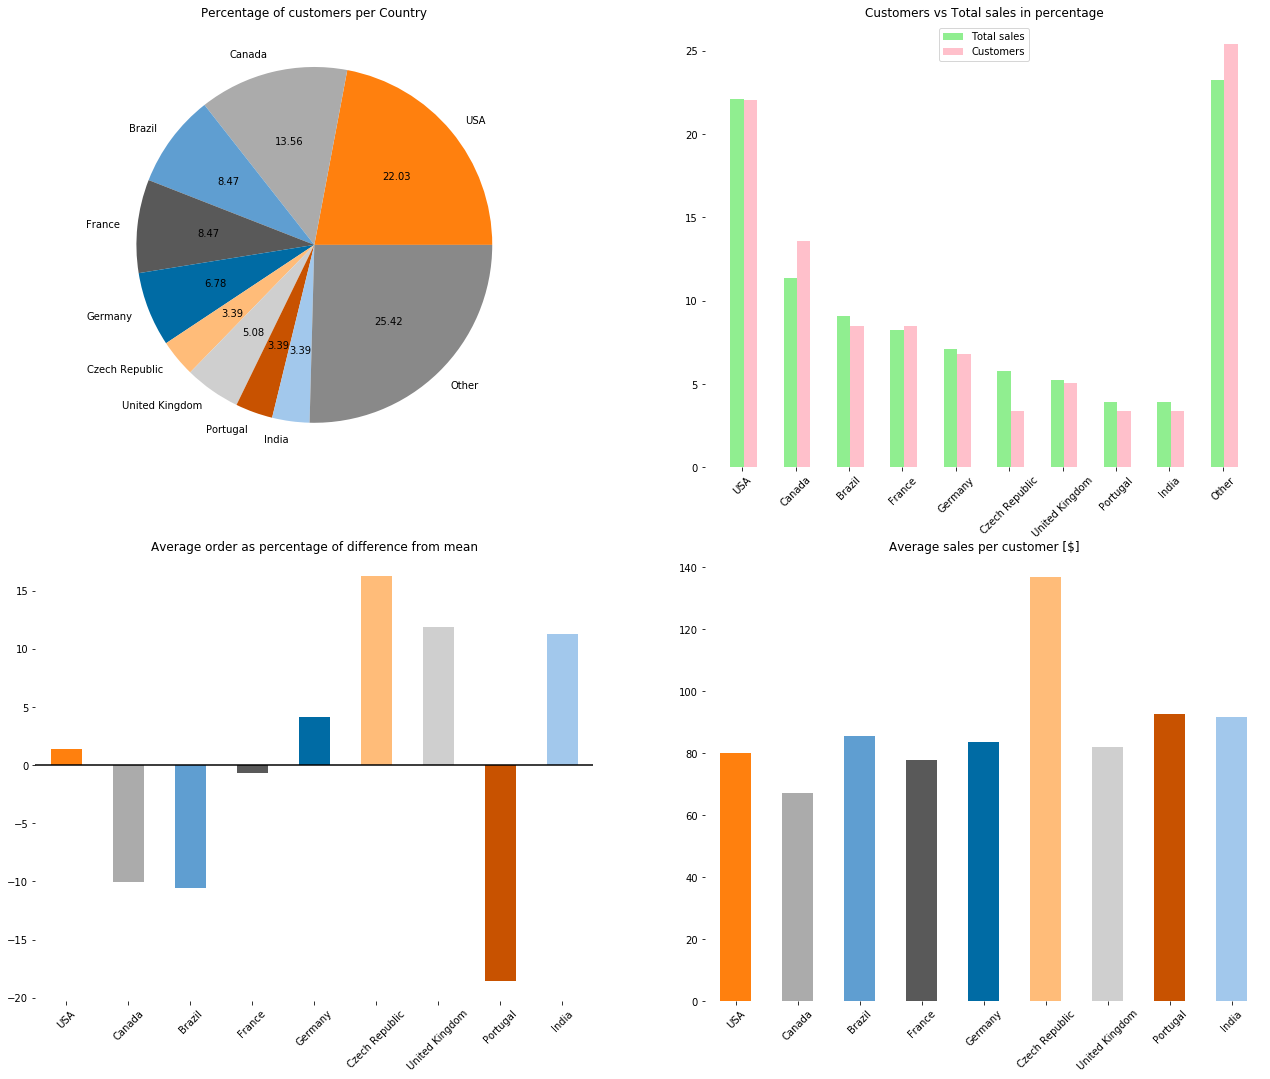

In [17]:
colors = [(255/255,128/255,14/255),
 (171/255,171/255,171/255),
 (95/255,158/255,209/255),
 (89/255,89/255,89/255),
 (0/255,107/255,164/255),
 (255/255,188/255,121/255),
 (207/255,207/255,207/255),
 (200/255,82/255,0/255),
 (162/255,200/255,236/255),
 (137/255,137/255,137/255)]

fig = plt.figure(figsize=(22, 18))

# pie chart
ax = fig.add_subplot(2,2,1)
ax.set_title('Percentage of customers per Country')
ax.pie(country_sales['number_of_customers'],labels=country_sales['country'],autopct='%.2f',colors=colors)
ax = fig.add_subplot(2,2,2)

country_sales['value_of_sales_pct'] = country_sales['value_of_sales']/country_sales['value_of_sales'].sum()*100
country_sales['number_of_customers_pct'] = country_sales['number_of_customers']/country_sales['number_of_customers'].sum()*100

# bar chart customer vs sales
bar_heights_1 = country_sales['value_of_sales_pct']
bar_positions_1 = np.arange(10) + 0.9
tick_positions = range(1,11)
ax.bar(bar_positions_1,bar_heights_1,0.25,color='lightgreen')
bar_heights_2 = country_sales['number_of_customers_pct']
bar_positions_2 = np.arange(10) + 1.15
ax.bar(bar_positions_2,bar_heights_2,0.25,color='pink')
ax.legend(['Total sales','Customers'],loc='upper center')
ax.set_title('Customers vs Total sales in percentage')
ax.set_xticks(tick_positions)
ax.set_xticks(tick_positions)
ax.set_xticklabels(country_sales['country'],rotation=45)
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)

# bar percentage diff
ax = fig.add_subplot(2,2,3)
ax.axhline(0,c=(0/255,0/255,0/255),alpha=1)
ax.set_title('Average order as percentage of difference from mean')
country_sales['dif_average_per_order'] = (country_sales['average_per_order']/country_sales['average_per_order'].mean() -1)*100
country_sales.iloc[:-1,:].plot(ax=ax,kind='bar',x='country',y='dif_average_per_order',rot=45,colors=colors[0:-1],legend=False,use_index=False)
ax.set_xticklabels(country_sales['country'][0:-1],rotation=45)
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)

# bar average sales per customer
ax = fig.add_subplot(2,2,4)
ax.set_title('Average sales per customer [$]')
country_sales.iloc[:-1,:].plot(ax=ax,kind='bar',x='country',y='average_sales_per_customer',rot=45,colors=colors[0:-1],legend=False,use_index=False)
ax.set_xticklabels(country_sales['country'][0:-1],rotation=45)
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)


As we can see on the graphs currently the biggest market is in the USA skaring over 22% of total sales. The second market is Canada with over 13% of total sales.
Czech, Portugal, India and Brazil are on top in terms of average sales per customer. If we look at average order as percentage of difference from mean of all orders we can see that Czech spend over 15% more per order then others following by India and UK where customers spend over 10% more per order then the average. Taking into account the amount of population, India may be the best choice to expand the advertising campaigns.

### Behavior of customers: Albums vs Tracks
Categorize each invoice as either an album purchase or not.

In [343]:
run_command('''
        CREATE VIEW invoice_whole_album AS 
        WITH 
        invoice_tracks AS
        
        (SELECT 
        il.invoice_id,
        il.track_id,
        t.album_id
        FROM invoice_line as il
        LEFT JOIN track as t ON t.track_id = il.track_id ),

        album_tracks AS

        (SELECT
        track_id,
        album_id
        FROM track)
              
              
        SELECT 
        il.invoice_id,
        CASE
            WHEN
                 (
                SELECT at.track_id
                FROM album_tracks as at
                WHERE album_id = (

                                    SELECT album_id
                                    FROM invoice_tracks as it
                                    WHERE it.invoice_id = il.invoice_id
                                    GROUP BY invoice_id

                                    )
                EXCEPT                 

                SELECT track_id
                FROM invoice_tracks as it
                WHERE it.invoice_id =il.invoice_id
                    ) IS NULL
                AND
                (SELECT count(at.track_id)
                FROM album_tracks as at
                WHERE album_id = (

                                    SELECT album_id
                                    FROM invoice_tracks as it
                                    WHERE it.invoice_id = il.invoice_id
                                    GROUP BY invoice_id

                                    )
                ) >2
                    
            THEN 'yes'
            ELSE 'no'
            END AS album_purchase
        
        FROM invoice_line as il
        GROUP BY invoice_id
            ''')

In [ ]:
# Print summary statistic
run_query('''
          SELECT
          album_purchase,
          COUNT(album_purchase) as total_invoices,
          COUNT(album_purchase)/ (SELECT CAST(COUNT(*) as Float) FROM invoice_whole_album) as percentage_of_invoices
          FROM invoice_whole_album
          GROUP BY album_purchase
          ''')

As we can see basend on summary statistic over 80 % of invoices consist of individual tracks insted of the whole album. Almost 20% of the market is turned by customers buying whole albums. So would suggest to perform some futher analysis in order to recommend any movements. Introducting a new functionality may cost us loosing some of the revenue if customers would buy only most popular songs alumns insted of whole ones.

Potential questions:
- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?